In [1]:
# https://www.kaggle.com/mathormad/inceptionv3-baseline-lb-0-379/code
# fork of scratch8, 29

In [2]:
%matplotlib inline
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras_metrics

import warnings
warnings.filterwarnings("ignore")
SIZE = 299

/home/watts/anaconda3/envs/hpg/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric/notebook
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1) + (1 - K.mean(f1))

In [4]:
# Load dataset info
path_to_train = '../data/train/'
data = pd.read_csv('../data/train.csv')

In [5]:
data.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
train_dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name),
        'labels':np.array([int(label) for label in labels])})
train_dataset_info = np.array(train_dataset_info)

In [7]:
train_dataset_info

array([{'path': '../data/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': '../data/train/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': '../data/train/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': '../data/train/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': '../data/train/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': '../data/train/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

In [8]:
from skimage import feature
from skimage.data import imread
import scipy.ndimage.filters as ndi

def canny_image(path, out1, out2):

    img = imread(path)
    im = img[:, :, 1]
    # im = ndi.gaussian_filter(img, 4)

    # Compute the Canny filter for two values of sigma
    edges1 = feature.canny(im, sigma=0.5)
    edges2 = feature.canny(im, sigma=2)



    plt.imsave(out1, edges1, cmap=plt.cm.gray)
    plt.imsave(out2, edges2, cmap=plt.cm.gray)

def canny_image2(path, out1, out2, out3, out4):

    img = imread(path)
    im = img[:, :, 1]
    print(im.shape)
    # im = ndi.gaussian_filter(img, 4)

    # Compute the Canny filter for two values of sigma
    edges1 = feature.canny(im, sigma=0.5)
    edges2 = feature.canny(im, sigma=1.)
    edges3 = feature.canny(im, sigma=1.5)
    edges4 = feature.canny(im, sigma=2)



    plt.imsave(out1, edges1)
    plt.imsave(out2, edges2)
    plt.imsave(out3, edges3)
    plt.imsave(out4, edges4)
    
def canny_image3(path, out1, out2, out3, out4):

    img = imread(path)
    
    im = ndi.gaussian_filter(img, 4)
    im = im[:, :, 1]
    print(im.shape)
    # Compute the Canny filter for two values of sigma
    edges1 = feature.canny(im, sigma=0.5)
    edges2 = feature.canny(im, sigma=1.)
    edges3 = feature.canny(im, sigma=1.5)
    edges4 = feature.canny(im, sigma=2)



    plt.imsave(out1, edges1)
    plt.imsave(out2, edges2)
    plt.imsave(out3, edges3)
    plt.imsave(out4, edges4)
    
def canny_image4(img):
#     cv2.imwrite('../cache/tmp1.png', img)
#     img = imread('../cache/tmp1.png')
    im = img[:, :, 1]
#     print(im.shape)
    # Compute the Canny filter for two values of sigma
#     edges1 = feature.canny(im, sigma=0.5)
#     edges2 = feature.canny(im, sigma=1.)
#     edges3 = feature.canny(im, sigma=1.5)
    edges4 = feature.canny(im, sigma=2)



#     plt.imsave(out1, edges1)
#     plt.imsave(out2, edges2)
#     plt.imsave(out3, edges3)
    
    plt.imsave('../cache/tmp', edges4)
    img_canny = cv2.imread('../cache/tmp')
#     print(edges4.shape)
#     img_canny = np.stack((np.array(edges4), np.array(edges4), np.array(edges4)), -1)
#     print(img_canny.shape)
    return img_canny

In [9]:
# tdi = np.memmap('../cache/tmp', dtype='float32', mode='w+', shape=(len(train_dataset_info),512,512,3))
# tdi = np.memmap('../cache/tmp', dtype='float32', mode='r', shape=(len(train_dataset_info),512,512,3))

In [10]:
def create_canny(path,idx):
    image_red_ch = Image.open(path+'_red.png')
    image_yellow_ch = Image.open(path+'_yellow.png')
    image_green_ch = Image.open(path+'_green.png')
    image_blue_ch = Image.open(path+'_blue.png')
    image1 = np.stack((
        np.array(image_red_ch),
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
    img = image1
    im = img[:, :, 1]
    edges4 = feature.canny(im, sigma=2)
    plt.imsave('../cache/tmp2', edges4)
    img_canny = cv2.imread('../cache/tmp2')
    tdi[idx] = img_canny

In [11]:
# for ii in tqdm(range(len(train_dataset_info))):
#     path = train_dataset_info[ii]['path']
#     create_canny(path, ii)

In [12]:
# tdi = np.memmap('../cache/tmp_rgb_canny', dtype='float32', mode='r', shape=(len(train_dataset_info),512,512,3))

In [13]:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)
#                     image = tdi[i+start]
#                     image = cv2.resize(image, (shape[0], shape[1]))
                    if augument:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image1 = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_red_ch),
#             np.array(image_green_ch), 
#             np.array(image_yellow_ch)), -1)
#         image3 = np.stack((
#             np.array(image_yellow_ch),
#             np.array(image_green_ch), 
#             np.array(image_blue_ch)), -1)
# #         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2, image3))
#         print(image.shape)
        image =image1
#         image = canny_image4(image1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def load_image2(path, shape):
        image_red_ch = Image.open(path+'_red.png')
        image_yellow_ch = Image.open(path+'_yellow.png')
        image_green_ch = Image.open(path+'_green.png')
        image_blue_ch = Image.open(path+'_blue.png')
        image1 = np.stack((
            np.array(image_red_ch),
            np.array(image_green_ch), 
            np.array(image_blue_ch)), -1)
        w, h = 512, 512
#         zero_data = np.zeros((h, w), dtype=np.uint8)
#         image2 = np.stack((
#             np.array(image_red_ch),
#             np.array(image_green_ch), 
#             np.array(image_yellow_ch)), -1)
#         image3 = np.stack((
#             np.array(image_yellow_ch),
#             np.array(image_green_ch), 
#             np.array(image_blue_ch)), -1)
# #         print(image1.shape, image2.shape)
#         image = np.vstack((image1, image2, image3))
#         print(image.shape)
        image =image1
#         image = canny_image4(image1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image
    
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)

        image_aug = augment_img.augment_image(image)
        return image_aug


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization, Input, Conv2D
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model

In [15]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
    bn = BatchNormalization(name='bn1')(input_tensor)
    x = base_model(bn)
    x = Conv2D(32, kernel_size=(1,1), activation='relu', name='conv1')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    
    return model

In [16]:
import tensorflow as tf
from tensorflow.python.ops import array_ops

# https://github.com/ailias/Focal-Loss-implement-on-Tensorflow/blob/master/focal_loss.py
def focal_loss_org(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)


In [17]:
def focal_loss(weights=None, alpha=0.25, gamma=2):
    def focal_loss_my(target_tensor, prediction_tensor, ):
        r"""Compute focal loss for predictions.
            Multi-labels Focal loss formula:
                FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                     ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
        Args:
         prediction_tensor: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing the predicted logits for each class
         target_tensor: A float tensor of shape [batch_size, num_anchors,
            num_classes] representing one-hot encoded classification targets
         weights: A float tensor of shape [batch_size, num_anchors]
         alpha: A scalar tensor for focal loss alpha hyper-parameter
         gamma: A scalar tensor for focal loss gamma hyper-parameter
        Returns:
            loss: A (scalar) tensor representing the value of the loss function
        """
        sigmoid_p = tf.nn.sigmoid(prediction_tensor)
        zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)

        # For poitive prediction, only need consider front part loss, back part is 0;
        # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
        pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)

        # For negative prediction, only need consider back part loss, front part is 0;
        # target_tensor > zeros <=> z=1, so negative coefficient = 0.
        neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
        per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                              - (1 - alpha) * (neg_p_sub ** gamma) * tf.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
        return tf.reduce_sum(per_entry_cross_ent)
#         return K.mean(K.binary_crossentropy(target_tensor, prediction_tensor), axis=-1) + tf.reduce_sum(per_entry_cross_ent)
    return focal_loss_my

In [18]:
def focal_loss_fixed(y_true, y_pred):
    gamma = 2.
    alpha = 0.25
    print(y_pred)
    print(y_true)
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#     pt_1 = K.clip(pt_1, 1e-3, .999)
#     pt_0 = K.clip(pt_0, 1e-3, .999)

    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


In [19]:
# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

#         pt_1 = K.clip(pt_1, 1e-3, .999)
#         pt_0 = K.clip(pt_0, 1e-3, .999)

#         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [20]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 10; batch_size = 16
checkpoint = ModelCheckpoint('../cache/InceptionV3-31.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                                   verbose=1, mode='auto', epsilon=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6)
callbacks_list = [checkpoint, early, reduceLROnPlat]


In [21]:

# split data into train, valid
indexes = np.arange(train_dataset_info.shape[0])
np.random.shuffle(indexes)
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.15, random_state=8)

# create train and valid datagens
train_generator = data_generator.create_train(
    train_dataset_info[train_indexes], batch_size, (SIZE,SIZE,3), augument=True)
validation_generator = data_generator.create_train(
    train_dataset_info[valid_indexes], 32, (SIZE,SIZE,3), augument=False)


In [22]:
# warm up model
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)

for layer in model.layers:
    layer.trainable = False
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True

In [23]:
# labels = np.zeros((28))
# labels[0] = 1
model.compile(
    loss=f1_loss, 
    optimizer=Adam(1e-03),
    metrics=[f1])
# model.summary()

In [24]:
model.load_weights('../cache/InceptionV3-8.h5')

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
conv1 (Conv2D)               (None, 8, 8, 32)          65568     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
__________

In [26]:
model.layers

In [27]:
model.layers[-6].output

<tf.Tensor 'conv1/Relu:0' shape=(?, 8, 8, 32) dtype=float32>

In [28]:
model.input

<tf.Tensor 'input_1:0' shape=(?, 299, 299, 3) dtype=float32>

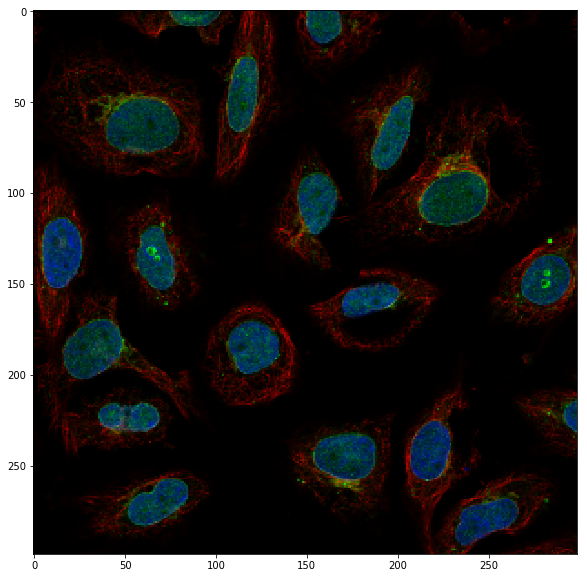

In [29]:
img = data_generator.load_image(train_dataset_info[1]['path'], (299, 299, 3))
plt.figure(figsize=(20,10))
plt.imshow(img)

In [30]:
print(img.shape)
img1 = img.reshape((1,299,299,3))
print(img1.shape)

(299, 299, 3)
(1, 299, 299, 3)


In [31]:
model.predict(img1)

array([[1.59421891e-01, 2.43720729e-02, 5.72899880e-05, 3.62318278e-05,
        9.89427441e-04, 3.18053574e-03, 6.54271935e-05, 3.68337933e-04,
        7.38749201e-11, 1.68816197e-10, 1.19053222e-11, 3.54725998e-05,
        2.58754697e-02, 1.79563102e-03, 9.97042935e-03, 1.67334324e-08,
        1.02068916e-04, 7.89484602e-07, 3.08752496e-05, 9.44023952e-04,
        1.57381677e-07, 2.16497689e-01, 3.45054269e-03, 6.54095085e-04,
        1.45725238e-07, 4.93382569e-03, 4.78388529e-07, 1.79261694e-09]],
      dtype=float32)

In [32]:
from keract import get_activations, display_activations
# ??get_activations

In [33]:
# ??display_activations

In [34]:
fig = plt.figure(figsize=(299,299))
ax = fig.add_subplot(1,1,1)
a = get_activations(model, img1/255.,'bn1')  # with just one sample.
# ??display_activations
display_activations(a)
# plt.imshow(a, interpolation='None', cmap='jet')

Displaying activation map 0


In [32]:
# img = data_generator.load_image(train_dataset_info[1]['path'], (299, 299, 3))
# img = img/255.
# img = deprocess_image(img)
# print(str(img.shape))
# from scipy.misc import imsave
# imsave('../cache/1.png',img)

# fig = plt.figure(figsize=(299,299))
# ax = fig.add_subplot(1,1,1)
# ax.imshow(img, cmap='gray')

NameError: name 'deprocess_image' is not defined

In [ ]:
img.shape

In [ ]:
img = data_generator.load_image(train_dataset_info[1]['path'], (299, 299, 3))
img1 = img.reshape((1,299,299,3))
img1 = img1/255.
label = np.zeros((1, 28))
label[0][train_dataset_info[1]['labels']] = 1
model.evaluate(img1, label)

In [91]:
model.input

<tf.Tensor 'input_4:0' shape=(?, 299, 299, 3) dtype=float32>

In [100]:
#pick a layer by name in the previous and put in the size.
img_width = 299
img_height = 299
lr = 1.
steps = 400
#get layer
# layer_dict = dict([(layer.name, layer) for layer in orig_model.layers])
layer_name = 'conv1'
filter_index = 42  # can be any integer from 0 to 511, if there are 512 filters in that layer
filter_index = 30

# a = Input(shape=(299,299,3))
# model = create_model(img, label)
# model.compile(
#     loss=f1_loss, 
#     optimizer=Adam(1e-03))
# model.load_weights('../cache/InceptionV3-8.h5')
input_img = model.input
# input_img = K.variable(value=img/255.)
# plt.imshow(input_img)
# input_img = tf.keras.backend.cast(img1,dtype='float32')
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
# layer_output = layer_dict[layer_name].output
layer_output = model.layers[-6].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]
print(grads)
# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

# we start from a gray image with some noise
if K.image_data_format() == 'channels_first':
    input_img_data = np.random.random((1, 3, img_width, img_height))
else:
    input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128

for i in range(steps):
    if i%20 == 0:
        print("%d/%d" % (i+1,steps))
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * lr


# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return np.squeeze(x)

img = input_img_data[0]
img = deprocess_image(img)
print(str(img.shape))
from scipy.misc import imsave
imsave('../cache/%s_filter_%d.png' % (layer_name, filter_index), img)

fig = plt.figure(figsize=(img_width,img_height))
ax = fig.add_subplot(1,1,1)
ax.imshow(img, cmap='gray')

TypeError: Error converting shape to a TensorShape: only size-1 arrays can be converted to Python scalars.

In [39]:
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=2, 
    verbose=1)

Epoch 1/2
1651/1651 [==============================] - 386s 234ms/step - loss: 1.1314 - f1: 0.0182 - val_loss: 1.1180 - val_f1: 4.0849e-04
Epoch 2/2
1651/1651 [==============================] - 137s 83ms/step - loss: 1.1234 - f1: 0.0165 - val_loss: 1.1187 - val_f1: 0.0206


In [40]:
# train all layers
epochs=120
for layer in model.layers:
    layer.trainable = True
model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(float(len(train_indexes)) / float(batch_size)),
    validation_data=validation_generator,
    validation_steps=np.ceil(float(len(valid_indexes)) / float(batch_size)),
    epochs=epochs, 
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/120
1651/1651 [==============================] - 380s 230ms/step - loss: 1.1229 - f1: 0.0184 - val_loss: 1.1180 - val_f1: 0.0206

Epoch 00001: val_loss improved from inf to 1.11804, saving model to ../cache/InceptionV3-30.h5
Epoch 2/120
1651/1651 [==============================] - 360s 218ms/step - loss: 1.1228 - f1: 0.0178 - val_loss: 1.1179 - val_f1: 0.0207

Epoch 00002: val_loss improved from 1.11804 to 1.11789, saving model to ../cache/InceptionV3-30.h5
Epoch 3/120
1651/1651 [==============================] - 357s 216ms/step - loss: 1.1226 - f1: 0.0184 - val_loss: 1.1177 - val_f1: 0.0207

Epoch 00003: val_loss improved from 1.11789 to 1.11774, saving model to ../cache/InceptionV3-30.h5
Epoch 4/120
1651/1651 [==============================] - 356s 215ms/step - loss: 1.1228 - f1: 0.0182 - val_loss: 1.1185 - val_f1: 0.0205

Epoch 00004: val_loss did not improve from 1.11774
Epoch 5/120
1651/1651 [==============================] - 356s 216ms/step - loss: 1.1227 - f1: 0.0182 - v

In [41]:
# Create submit
submit = pd.read_csv('../data/sample_submission.csv')
predicted = []
draw_predict = []
model = create_model(
    input_shape=(SIZE,SIZE,3), 
    n_out=28)
for layer in model.layers:
    layer.trainable = True
model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=[f1])
model.load_weights('../cache/InceptionV3-30.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('../data/test/', name)
    image = data_generator.load_image(path, (SIZE,SIZE,3))/255.
    score_predict = model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
# np.save('../cache/draw_predict_InceptionV3-30.npy', score_predict)
# submit.to_csv('../submissions/submit_InceptionV3.csv', index=False)

100%|██████████| 11702/11702 [29:31<00:00,  7.13it/s]


In [42]:
submit.to_csv('../submissions/sub30.csv', index=False)

In [43]:
#https://stackoverflow.com/questions/1855095/how-to-create-a-zip-archive-of-a-directory
def backup_project_as_zip(project_dir, zip_file):
    assert(os.path.isdir(project_dir))
    assert(os.path.isdir(os.path.dirname(zip_file)))
    shutil.make_archive(zip_file.replace('.zip',''), 'zip', project_dir)
    pass

In [44]:
import datetime, shutil
now = datetime.datetime.now()
print(now)
PROJECT_PATH = '/home/watts/lal/Kaggle/kagglehp/scripts_nbs'
backup_project_as_zip(PROJECT_PATH, '../cache/code.scripts_nbs.%s.zip'%now)

2018-11-09 12:32:16.027367


In [45]:
%%time
!kaggle competitions submit -c human-protein-atlas-image-classification -f ../submissions/sub30.csv -m ""

100%|████████████████████████████████████████| 480k/480k [00:08<00:00, 52.9kB/s]
Successfully submitted to Human Protein Atlas Image ClassificationCPU times: user 585 ms, sys: 268 ms, total: 853 ms
Wall time: 26.8 s


In [46]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName      date                 description  status    publicScore  privateScore  
------------  -------------------  -----------  --------  -----------  ------------  
sub30.csv     2018-11-09 07:02:56               complete  0.033        None          
sub29.csv     2018-11-08 22:07:11               complete  0.389        None          
sub28-c.csv   2018-11-08 15:47:08               complete  0.457        None          
sub28-bb.csv  2018-11-08 15:46:13               complete  0.458        None          
sub28-b.csv   2018-11-08 15:45:28               complete  0.454        None          
sub28-a.csv   2018-11-08 15:44:27               complete  0.454        None          
sub25.csv     2018-11-07 10:45:12               complete  0.421        None          
sub25.csv     2018-11-07 10:26:20               complete  0.421        None          
sub8a.csv     2018-11-07 05:53:08               complete  0.425        None          
sub24.csv     2018-11-07 05:09:26               comple

In [26]:
from time import sleep
sleep(60)
!kaggle competitions submissions -c human-protein-atlas-image-classification

fileName  date                 description  status    publicScore  privateScore  
--------  -------------------  -----------  --------  -----------  ------------  
sub8.csv  2018-10-20 20:08:45               complete  0.422        None          
sub7.csv  2018-10-20 17:06:09               complete  0.389        None          
sub5.csv  2018-10-19 18:27:33               complete  0.387        None          
sub4.csv  2018-10-19 14:45:15               complete  0.411        None          
sub3.csv  2018-10-19 10:19:26               complete  0.377        None          
sub2.csv  2018-10-19 08:07:30               complete  0.135        None          
sub1.csv  2018-10-19 06:28:57               complete  0.374        None          
